Full 31-day WINTER RAIN data saved → synthetic_solar_winter_rain.csv

Last 25h solar: 25 rows
   From: 2021-01-30 00:00:00
   To:   2021-01-31 00:00:00
Last 25 hours saved → last_25h_solar.csv


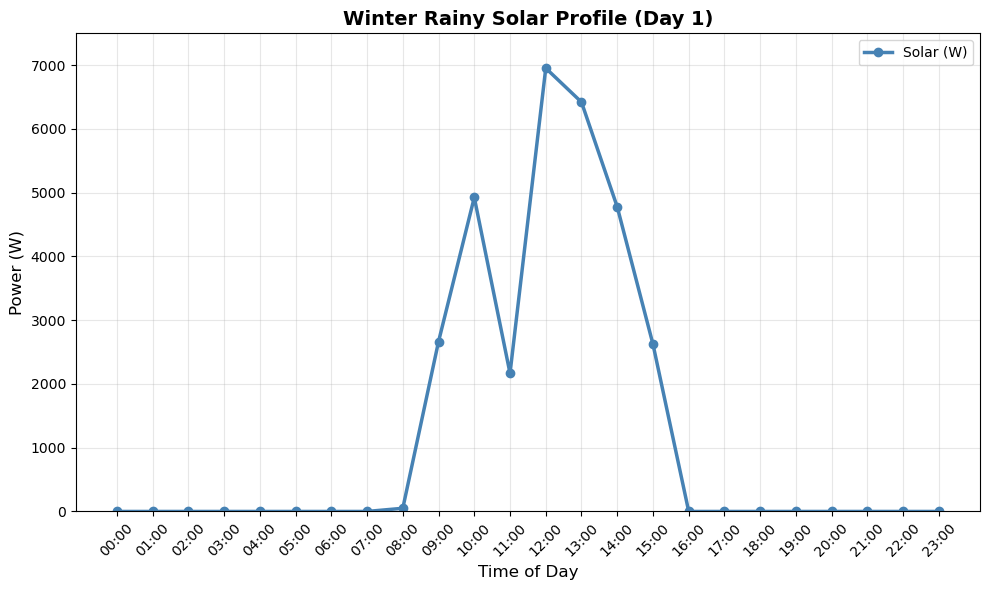

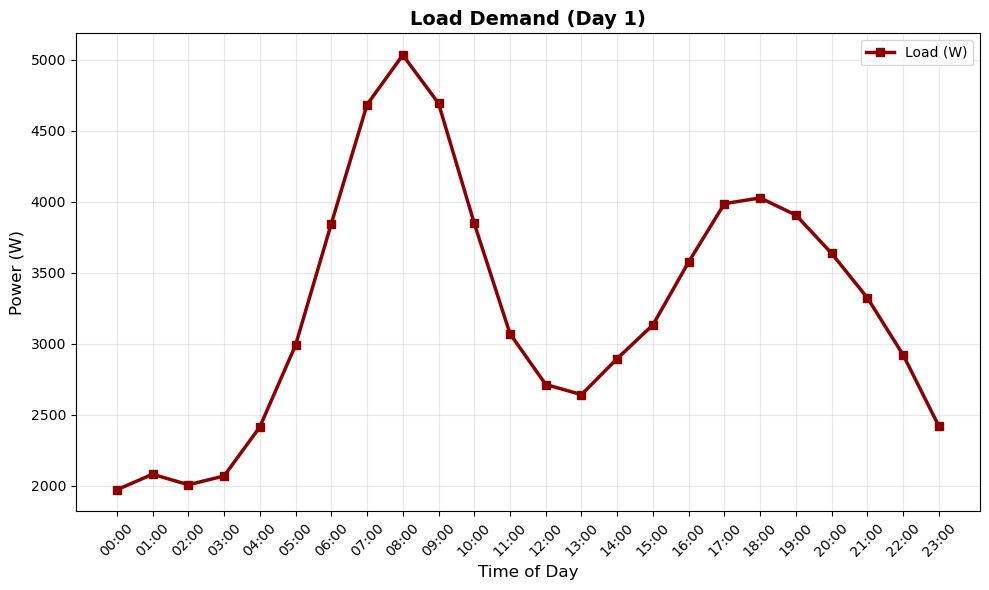

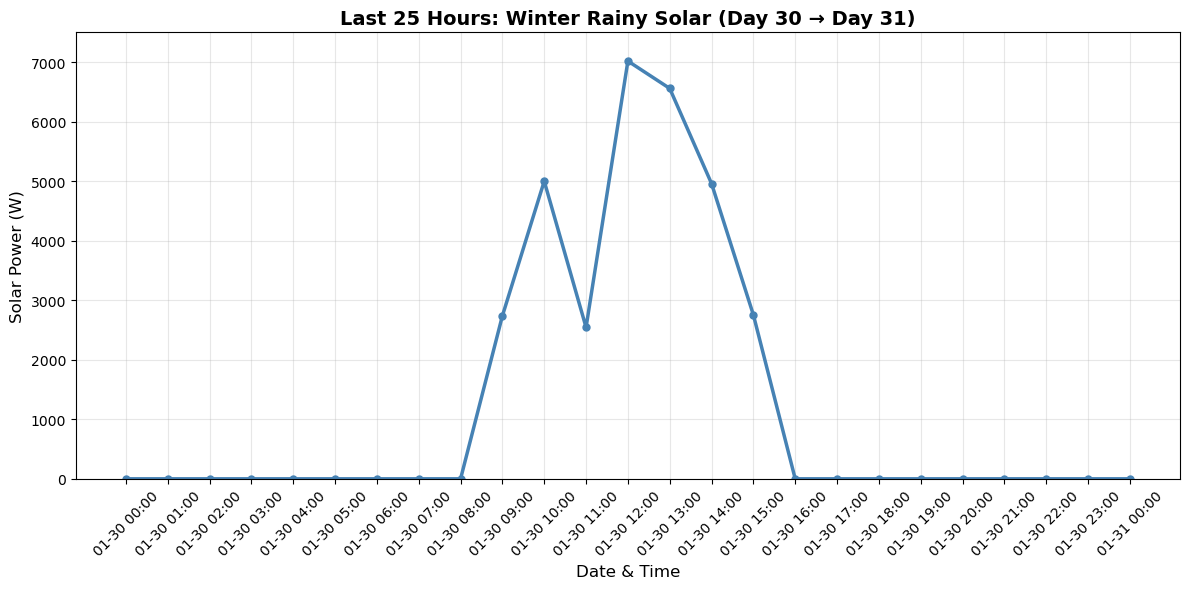

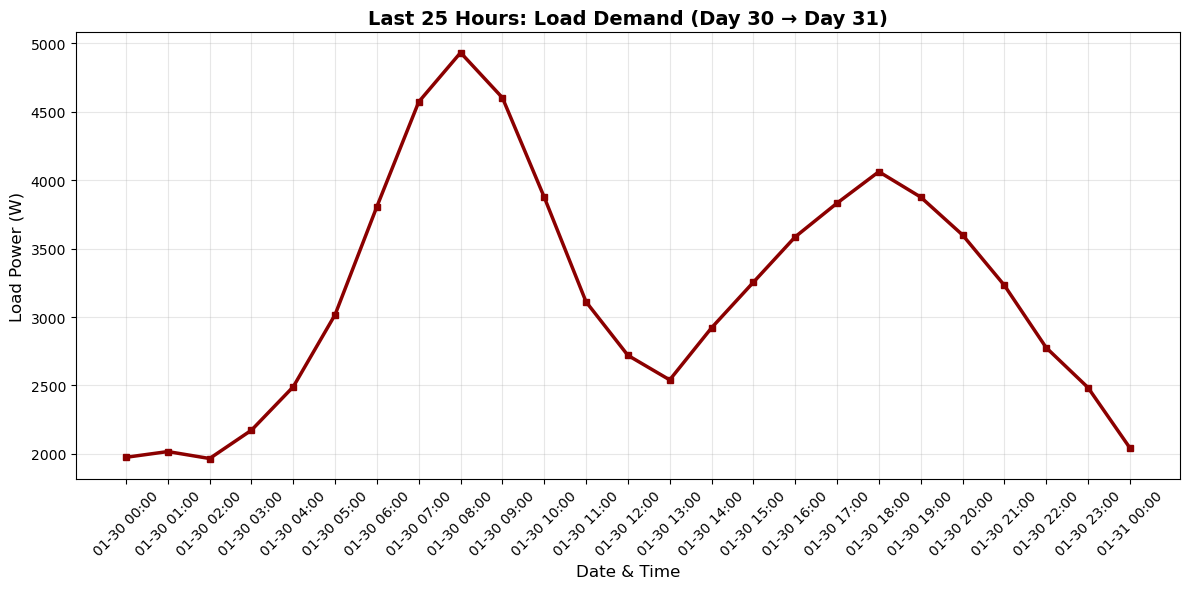


All done! (Winter Rainy Edition)
   • synthetic_solar_winter_rain.csv → 0–6 kW with rain disturbance
   • last_25h_solar_winter_rain.csv  → 25 rows (rainy day 30–31)
   • Plots show sharp drops during simulated cloud bursts


In [3]:
# ----------------------------------------------------------------------
#  generate_synthetic_data_with_last_25h_WINTER_RAIN.py
#  → Full 31-day data + LAST 25 HOURS (00:00 day 30 → 00:00 day 31)
#  → WINTER RAINY: 0–6 kW, 8 AM–4 PM, heavy cloud/rain disturbance
# ----------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# 1. Generate 31 days of hourly data (744 points)
# ----------------------------------------------------------------------
total_days = 31
hours = np.arange(0, 24 * total_days)
np.random.seed(42)  # For reproducibility

# ----------------------------------------------------------------------
# WINTER RAINY SOLAR: 8 AM – 4 PM, peak 6 kW + rain disturbance
# ----------------------------------------------------------------------
solar = np.zeros_like(hours, dtype=float)

for h in range(len(hours)):
    hour_of_day = h % 24
    day_idx = h // 24

    # Base winter profile: 8 AM – 4 PM, peak 6 kW
    if 8 <= hour_of_day < 16:
        t = (hour_of_day - 8) / 8.0  # 0 to 1
        base_solar = 7000 * np.sin(np.pi * t) + np.random.normal(0, 100)  # ±100 W noise
        base_solar = max(base_solar, 0)
    else:
        base_solar = 0

    # Apply rain disturbance (only on random days)
    if base_solar > 0:
        # 20% chance per day to have rain events
        if np.random.rand() < 0.2:
            # Simulate 1–3 rain events per day
            num_events = np.random.randint(1, 4)
            for _ in range(num_events):
                start_hour = np.random.randint(8, 13)  # Rain likely morning/afternoon
                duration = np.random.randint(1, 4)    # 1–3 hours
                end_hour = start_hour + duration

                if start_hour <= hour_of_day < end_hour:
                    # Heavy cloud: reduce 60–90%
                    reduction = np.random.uniform(0.6, 0.9)
                    base_solar *= (1 - reduction)
                    break  # One event at a time

    solar[h] = max(base_solar, 0)

# ----------------------------------------------------------------------
# Load: same as before (baseline + peaks)
# ----------------------------------------------------------------------
base = 2000
morning_peak = 3000 * np.exp(-((hours % 24 - 8) ** 2 / (2 * 2 ** 2)))
evening_peak = 2000 * np.exp(-((hours % 24 - 18) ** 2 / (2 * 3 ** 2)))
load = base + morning_peak + evening_peak + np.random.normal(0, 50, len(hours))

# ----------------------------------------------------------------------
# 2. Create full DataFrames
# ----------------------------------------------------------------------
timestamps = pd.date_range(start='2021-01-01', periods=len(hours), freq='h')

df_solar = pd.DataFrame({
    'timestamp': timestamps,
    'solar': solar
})
df_load = pd.DataFrame({
    'timestamp': timestamps,
    'load': load
})

# ----------------------------------------------------------------------
# 3. Save full 31-day data
# ----------------------------------------------------------------------
df_solar.to_csv('synthetic_solar.csv', index=False)
df_load.to_csv('synthetic_load.csv', index=False)
print(f"Full {total_days}-day WINTER RAIN data saved → synthetic_solar_winter_rain.csv")

# ----------------------------------------------------------------------
# 4. Extract LAST 25 HOURS: 00:00 day 30 → 00:00 day 31
# ----------------------------------------------------------------------
start_idx = 29 * 24  # 696
end_idx = start_idx + 25

last_25h_solar = df_solar.iloc[start_idx:end_idx].copy()
last_25h_load  = df_load.iloc[start_idx:end_idx].copy()

print(f"\nLast 25h solar: {len(last_25h_solar)} rows")
print(f"   From: {last_25h_solar['timestamp'].iloc[0]}")
print(f"   To:   {last_25h_solar['timestamp'].iloc[-1]}")

last_25h_solar.to_csv('last_25h_solar.csv', index=False)
last_25h_load.to_csv('last_25h_load.csv', index=False)
print("Last 25 hours saved → last_25h_solar.csv")

# ----------------------------------------------------------------------
# 5. Plot first 24h (Day 1) – Winter Rainy
# ----------------------------------------------------------------------
hours_only = df_solar['timestamp'][:24].dt.strftime('%H:%M')

plt.figure(figsize=(10, 6))
plt.plot(hours_only, df_solar['solar'][:24], color='steelblue', linewidth=2.5, marker='o', markersize=6, label='Solar (W)')
plt.title('Winter Rainy Solar Profile (Day 1)', fontsize=14, fontweight='bold')
plt.ylabel('Power (W)', fontsize=12)
plt.xlabel('Time of Day', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.ylim(0, 7500)
plt.legend()
plt.tight_layout()
plt.savefig('solar_profile_24h_winter_rain.png', dpi=300, bbox_inches='tight')
plt.show()

# Load plot
plt.figure(figsize=(10, 6))
plt.plot(hours_only, df_load['load'][:24], color='darkred', linewidth=2.5, marker='s', markersize=6, label='Load (W)')
plt.title('Load Demand (Day 1)', fontsize=14, fontweight='bold')
plt.ylabel('Power (W)', fontsize=12)
plt.xlabel('Time of Day', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('load_profile_24h.png', dpi=300, bbox_inches='tight')
plt.show()

# ----------------------------------------------------------------------
# 6. Plot LAST 25 HOURS – Winter Rainy
# ----------------------------------------------------------------------
last_hours = last_25h_solar['timestamp'].dt.strftime('%m-%d %H:%M')

plt.figure(figsize=(12, 6))
plt.plot(last_hours, last_25h_solar['solar'], color='steelblue', linewidth=2.5, marker='o', markersize=5)
plt.title('Last 25 Hours: Winter Rainy Solar (Day 30 → Day 31)', fontsize=14, fontweight='bold')
plt.ylabel('Solar Power (W)', fontsize=12)
plt.xlabel('Date & Time', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.ylim(0, 7500)
plt.tight_layout()
plt.savefig('last_25h_solar_plot_winter_rain.png', dpi=300, bbox_inches='tight')
plt.show()

# Load plot
plt.figure(figsize=(12, 6))
plt.plot(last_hours, last_25h_load['load'], color='darkred', linewidth=2.5, marker='s', markersize=5)
plt.title('Last 25 Hours: Load Demand (Day 30 → Day 31)', fontsize=14, fontweight='bold')
plt.ylabel('Load Power (W)', fontsize=12)
plt.xlabel('Date & Time', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('last_25h_load_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAll done! (Winter Rainy Edition)")
print("   • synthetic_solar_winter_rain.csv → 0–6 kW with rain disturbance")
print("   • last_25h_solar_winter_rain.csv  → 25 rows (rainy day 30–31)")
print("   • Plots show sharp drops during simulated cloud bursts")